# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle
from condensate_speckle.data_io import*
from condensate_speckle.inference.model import*
from condensate_speckle.inference.simulation import *

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/wenyun/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
az.style.use("arviz-darkgrid")

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

## simulate single time scale

In [3]:
number_of_points=5000
tau=10
quantization=255
intensity_mean=80
intensity_std=20
camera_noise=5
camera_std=1

The set mean of innovation is 7.613006557123239
The set std of innovation is 8.515145258232963


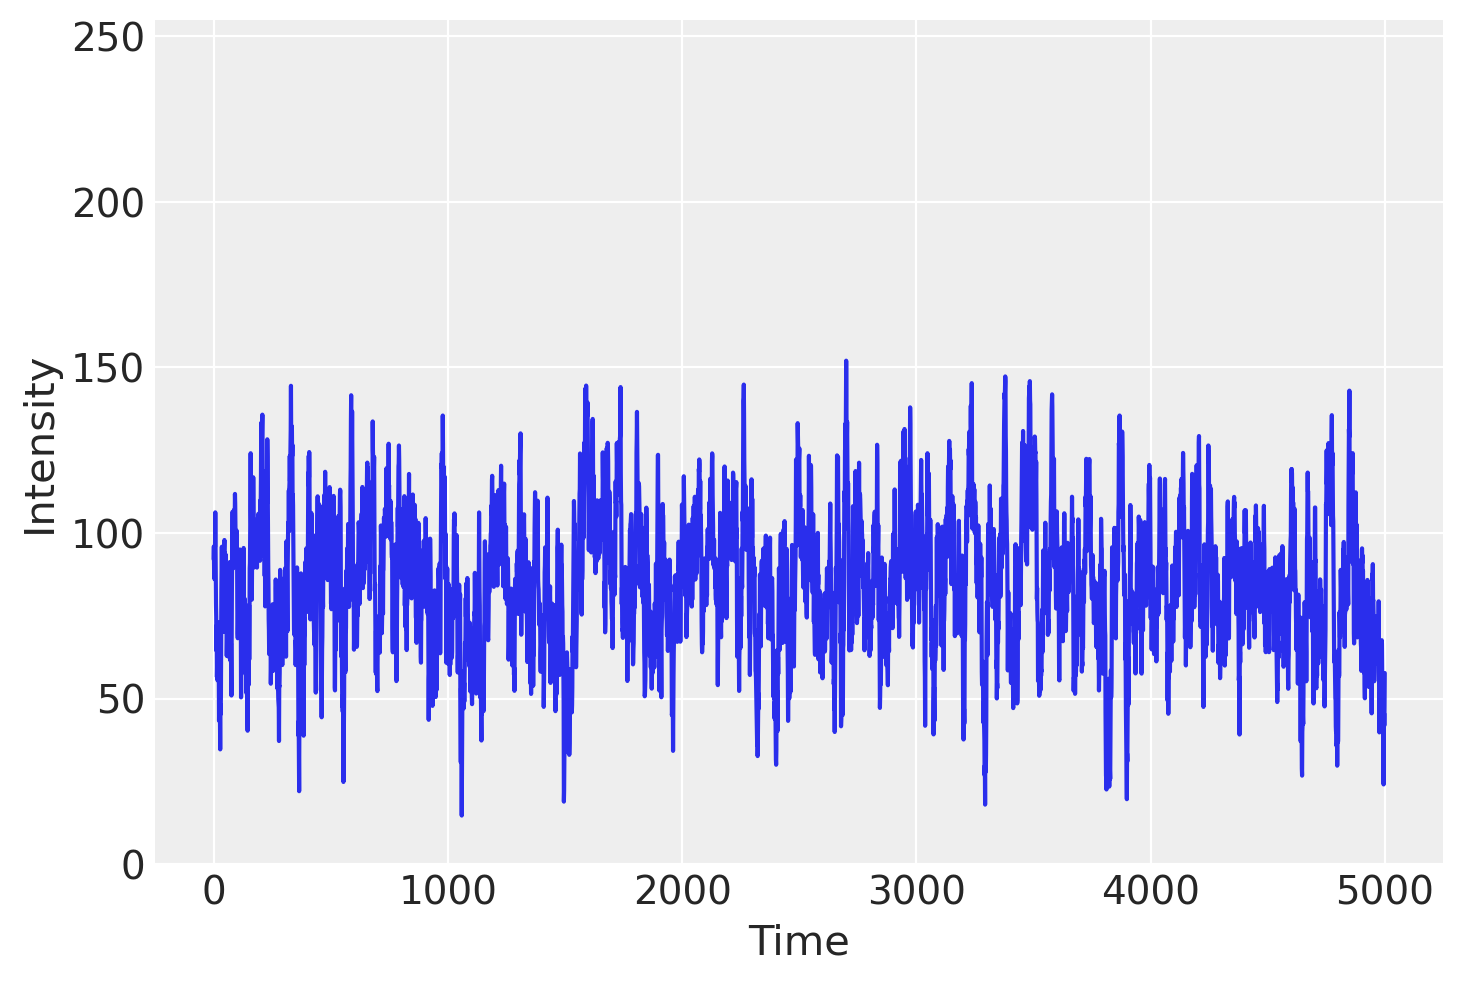

the mean of simulated data is 85.14427497720011
the std of simulated data is 20.448424577995834


In [4]:
simulated_data_single, simulated_t_single=simulate_single_decay_data(number_of_points,tau, quantization, intensity_mean, intensity_std, camera_noise, camera_std)

## simulate 2 time scales

In [6]:
number_of_points=5000
tau_1=3
tau_2=300
relative_var=0.5
quantization=255
intensity_mean=80
intensity_std=40
camera_noise=8
camera_std=3

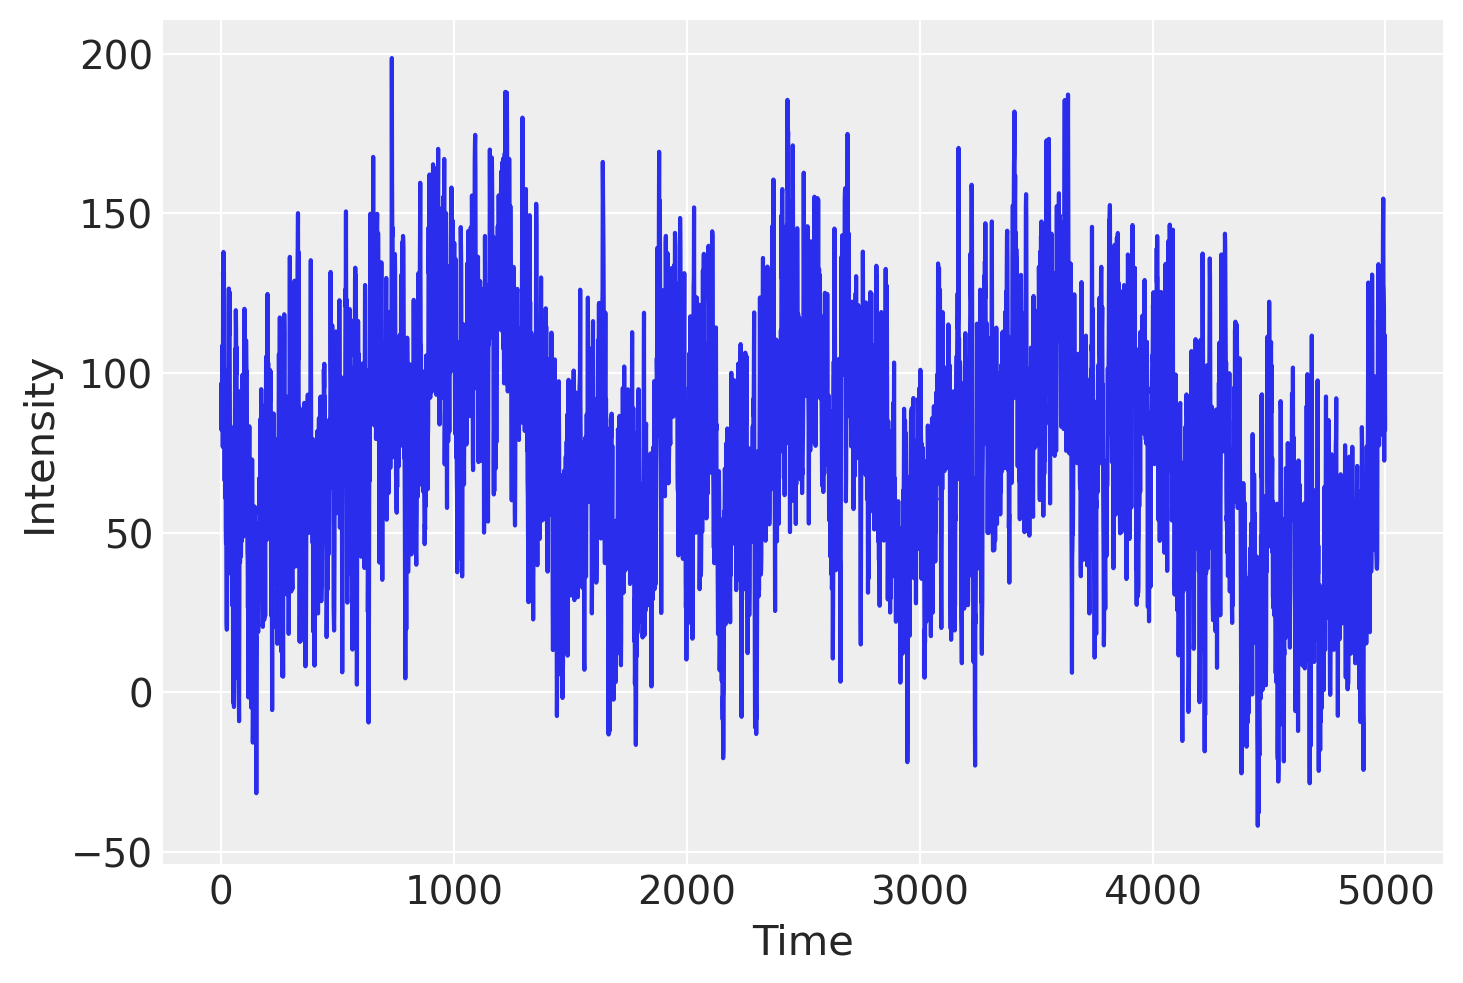

the mean of camera noise data is 8.03359883983314
the std of camera noise data is 3.0248214938016926
the mean of fast simulated data is 0.29090844668696925
the mean of slow simulated data is -11.677939644765859
the mean of simulated data is 76.64656764175425
the std of simulated data is 37.10323062499084
the (variance/mean^2) of simulated data is 0.23433546947532602


In [18]:
simulated_data_double, simulated_t_double=simulate_double_decay_data(number_of_points,tau_1,tau_2, relative_var,quantization, intensity_mean, intensity_std, camera_noise, camera_std)

# Load in real data

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[100, 117]_7h_intensity.csv


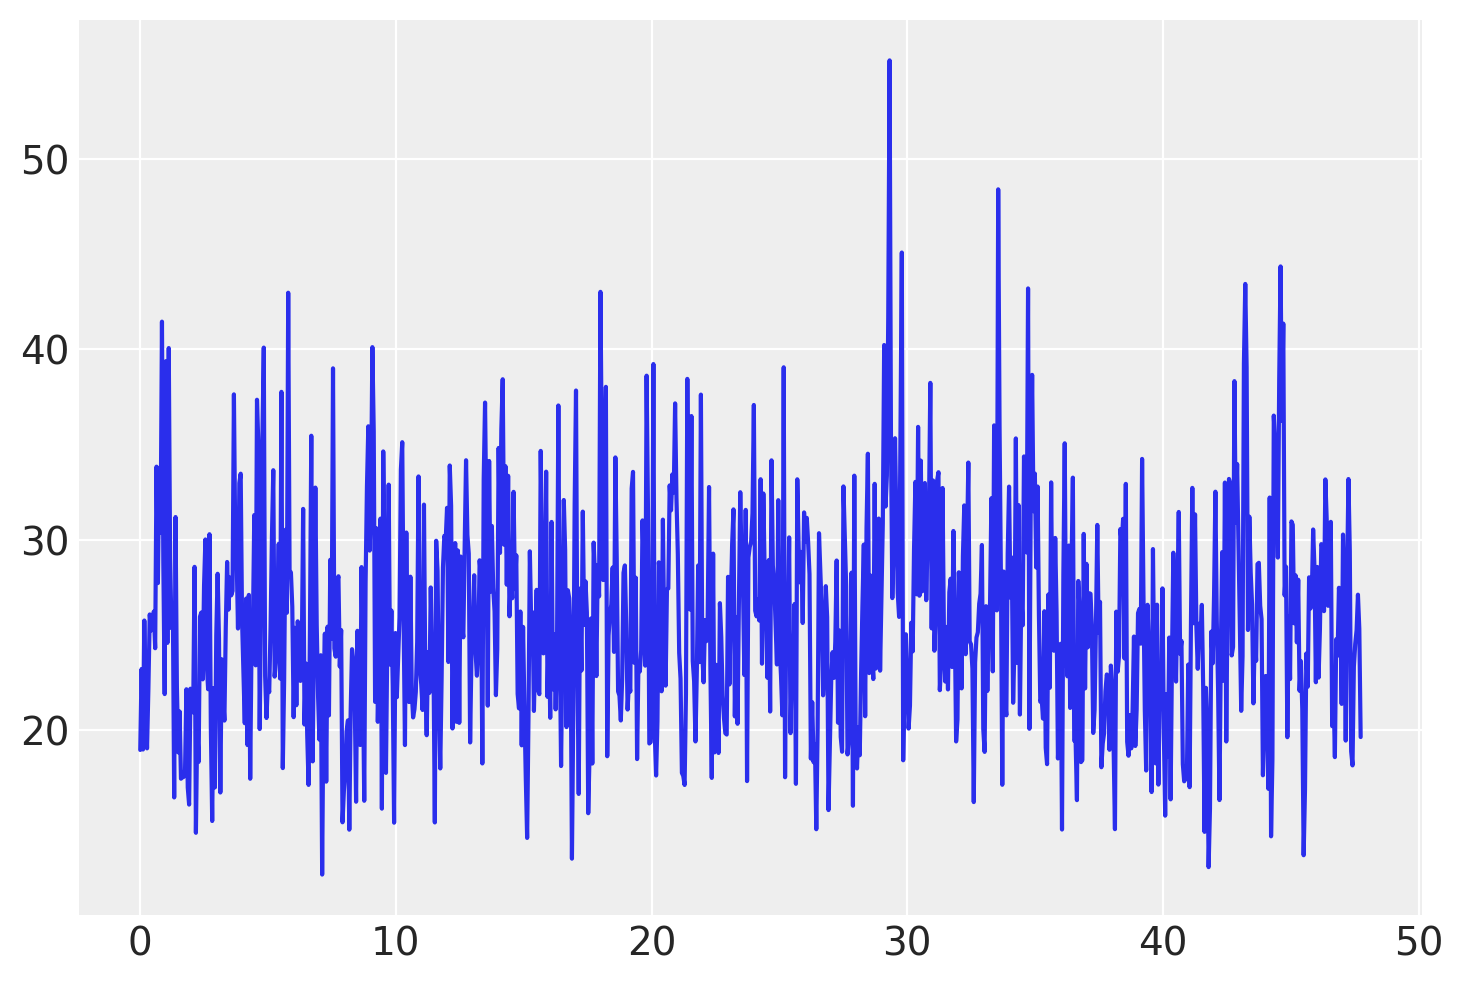

In [31]:
#Load in real data and plot
dataframe = load_data('[100, 117]_7h_intensity.csv',data_dir='condensate_speckle/example_data')

# Infer decay time from data using the AR(1) model in pymc3

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [32]:
# Define ar1 model
quantization = 255
ar1_model=set_model(dataframe['Intensity'],quantization)

In [ ]:
# Sample with pymc3 using the single timescale model
trace_single_model, idata = run_model(ar1_model)

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/inference/model.py:104: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws, tune=tune, init=init, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 106700
Interrupted at 106,699 [53%]: Average Loss = 3,131.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 48 seconds.


In [ ]:
plot_posterior(trace_single_model)

In [ ]:
plot_trace(trace_single_model)

# Infer decay time from data using the 2*AR(1) model in pymc3

In [12]:
ar1_multi_model=set_double_scale_model(dataframe['Intensity'], quantization)

In [13]:
# Sample with pymc3 using the double timescale model
trace_multi_model, idata_multi_model = run_model(ar1_multi_model)

/Users/anqichen/Documents/GitHub/condensate_speckles/condensate_speckle/inference/model.py:104: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws, tune=tune, init=init, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,703.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y2, y1, noise_std, precision_2, precision_1, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


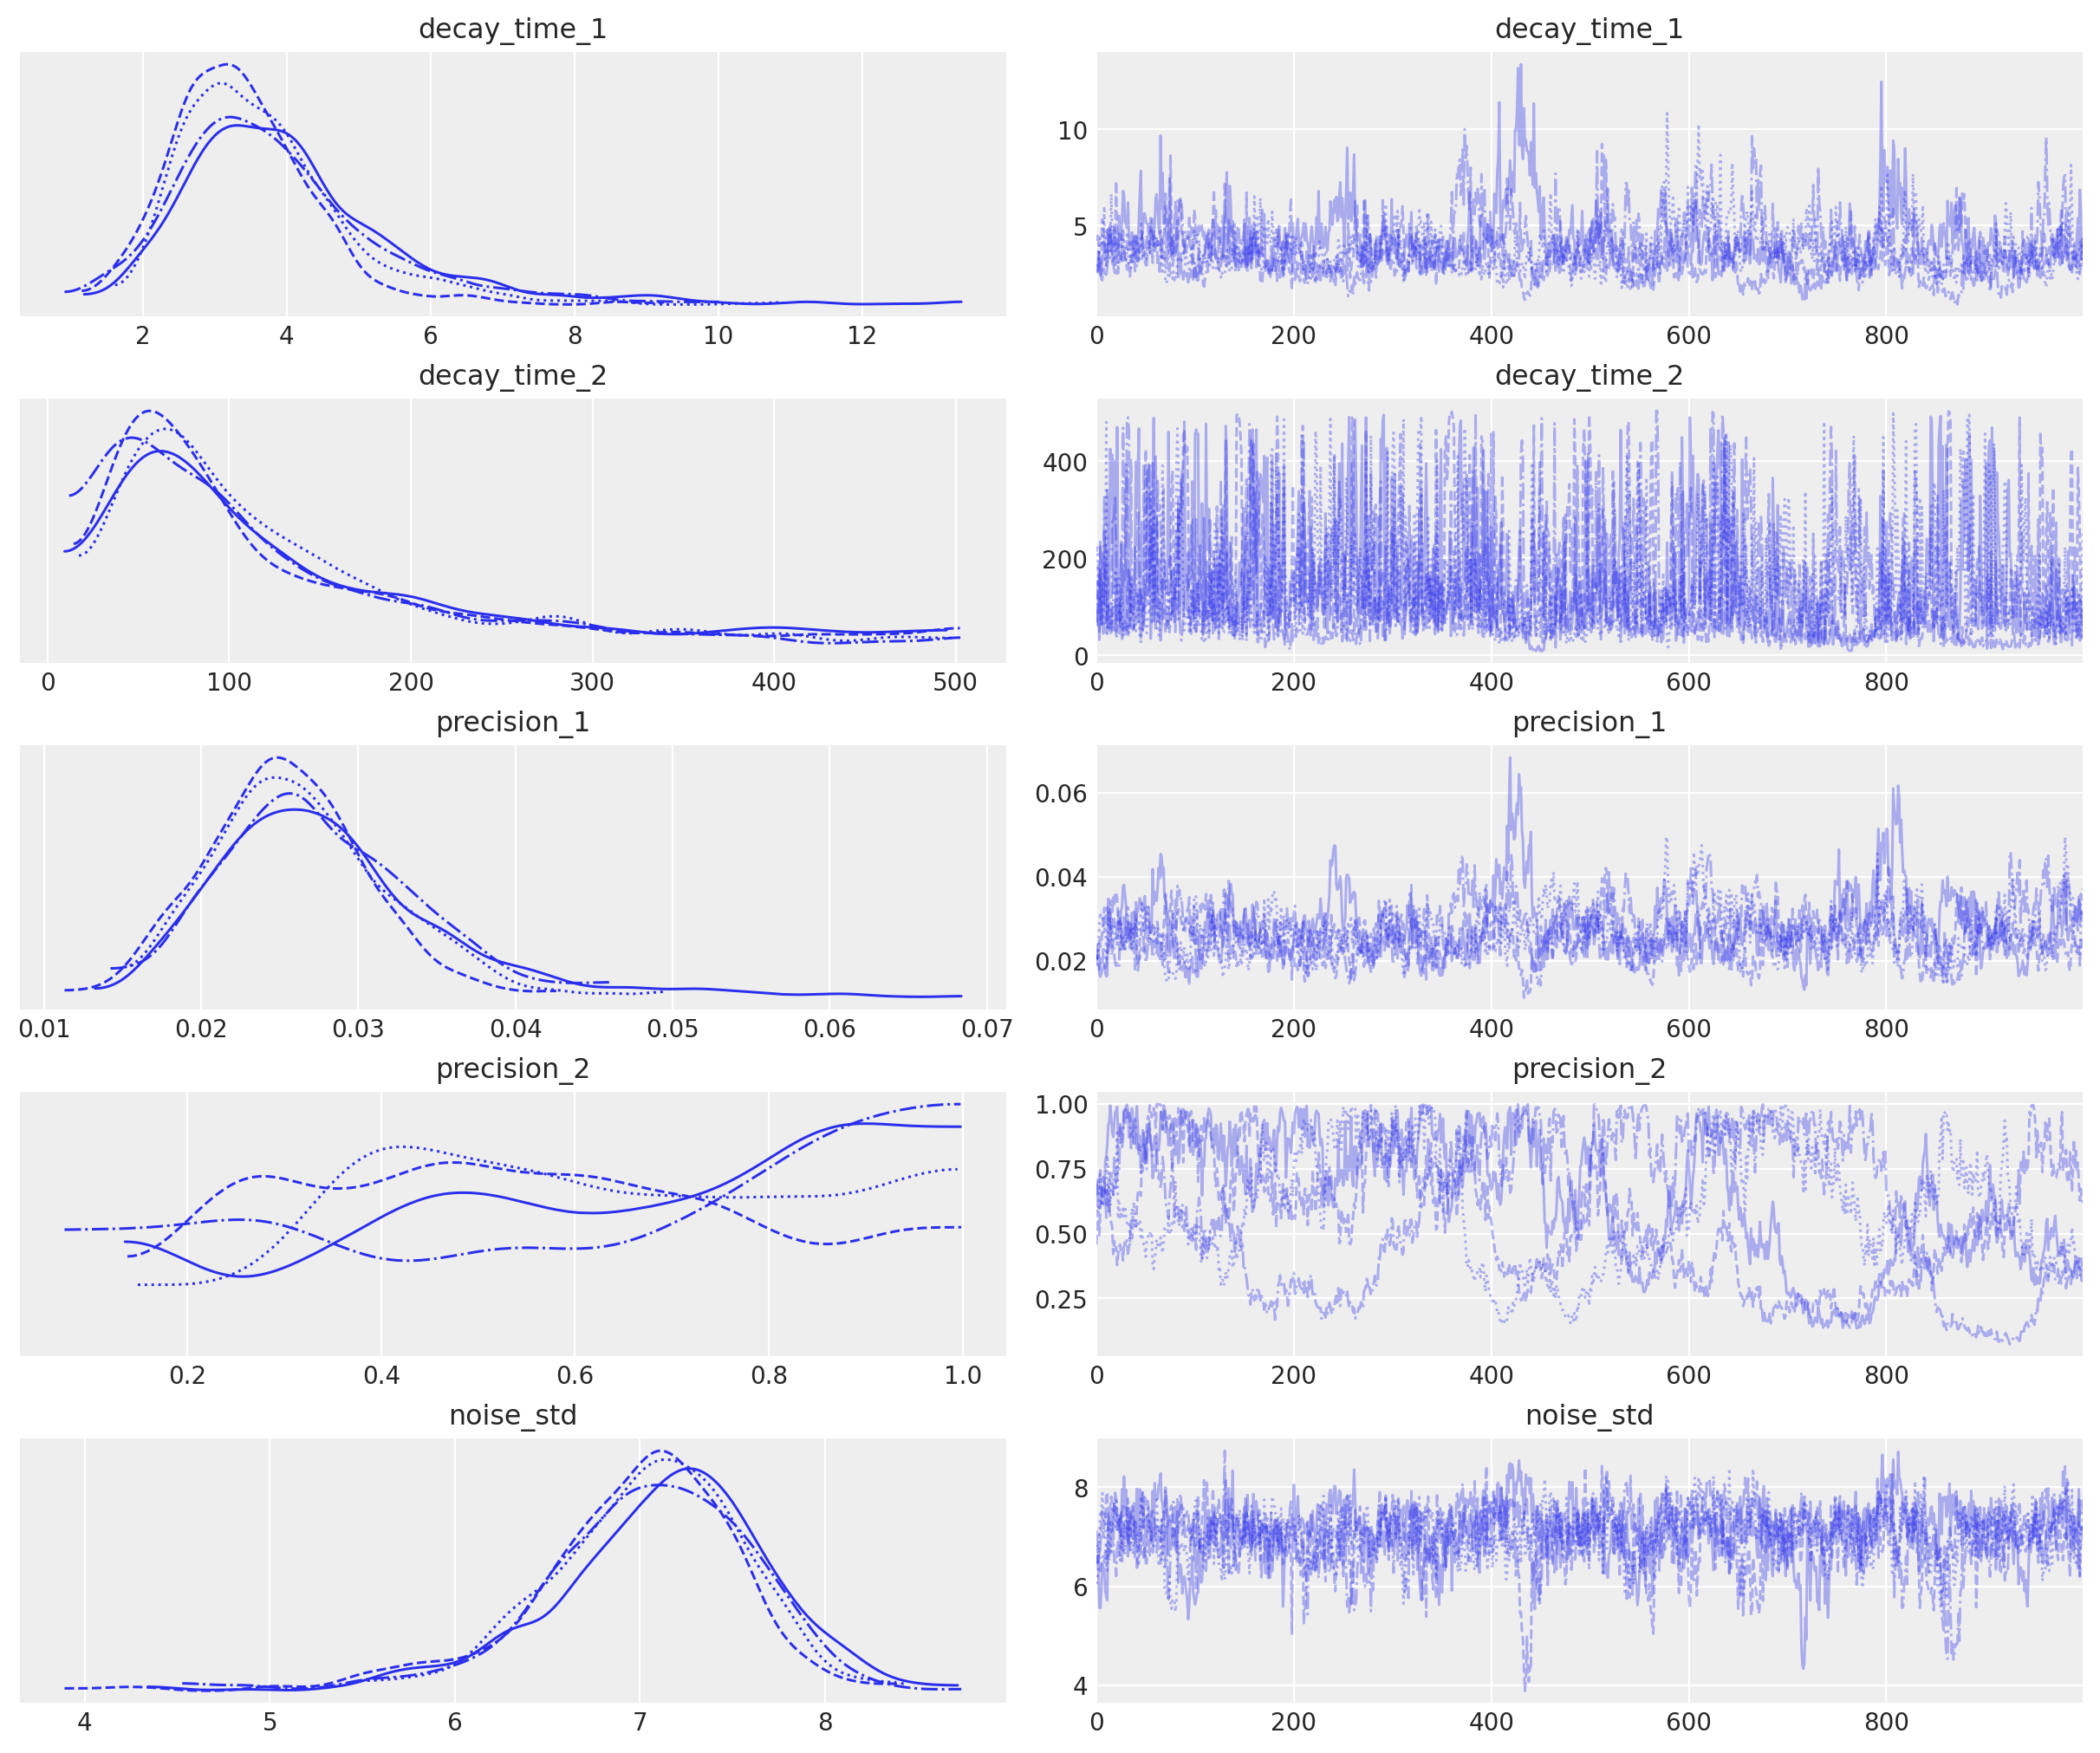

In [19]:
plot_trace(trace_multi_model, n_time_scale = 2)

/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


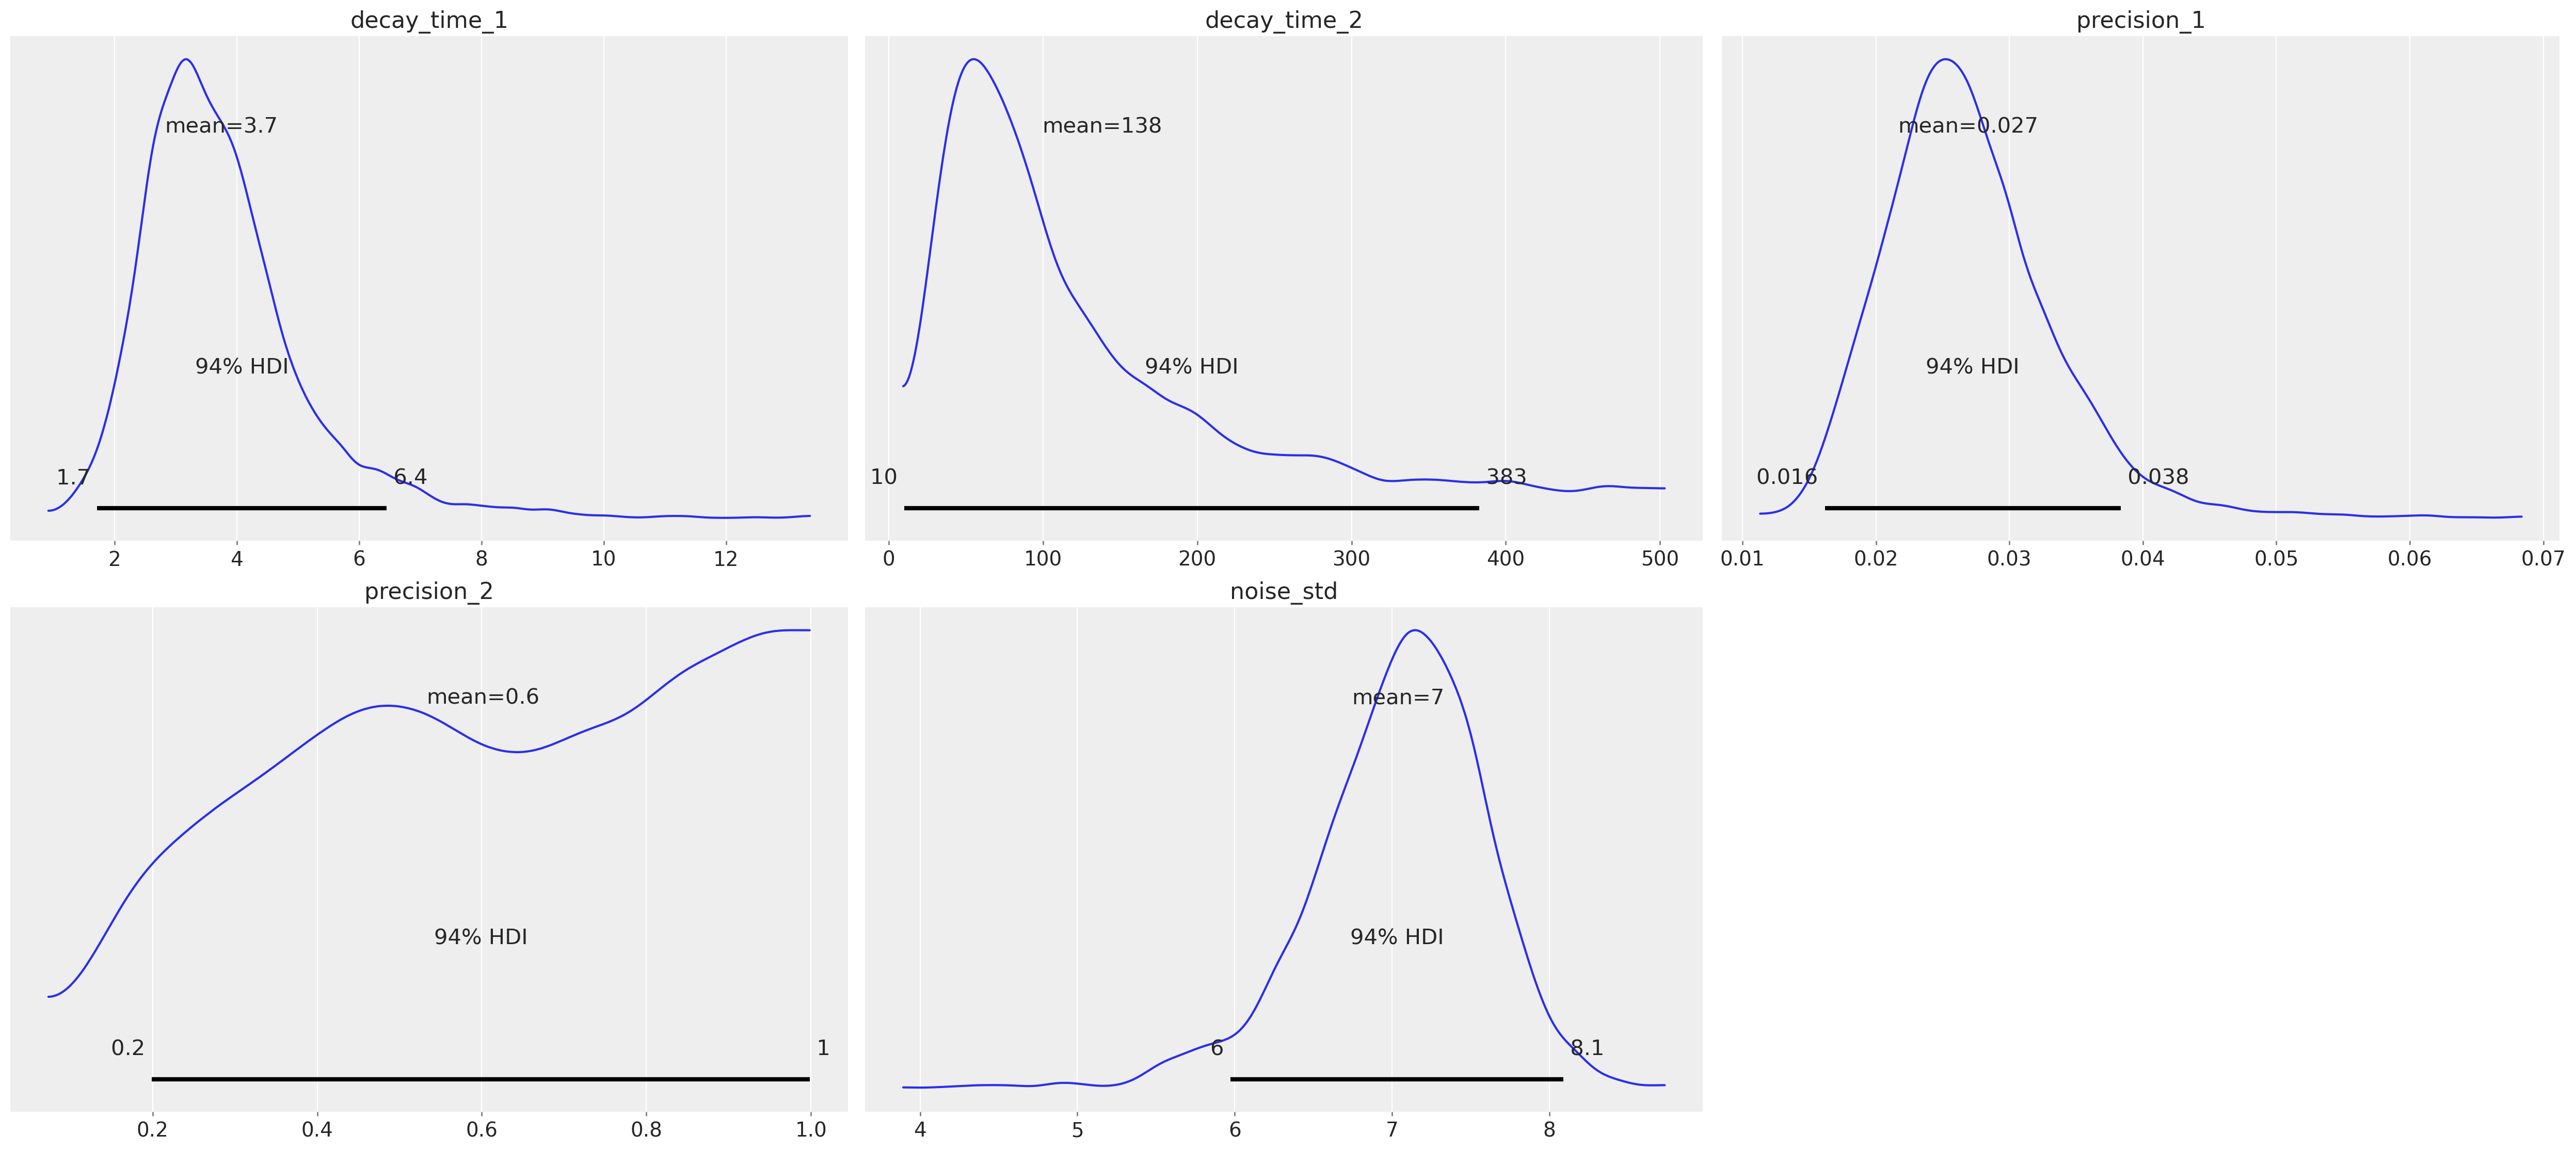

In [20]:
plot_posterior(trace_multi_model, n_time_scale = 2)